# Explore trade-weighted dollar indices on the FRED

Compare other USD currency pairs with trade-weighted indices

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(quantmod)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

fred<-Fred()

In [2]:
cutoff <- Sys.Date() - 15
fred$Meta() %>% inner_join(fred$TimeSeries(), by = 'SERIES_ID') %>%
    filter(NAME %like% '%dollar%' & FREQUENCY == 'D') %>%
    group_by(SERIES_ID, TICKER, NAME) %>%
    summarize(MIN_TS = min(TIME_STAMP), MAX_TS = max(TIME_STAMP)) %>%
    filter(MAX_TS >= cutoff) %>%
    select(SERIES_ID, TICKER, NAME, MIN_TS, MAX_TS) %>%
    print(n=Inf)

# Source:   lazy query [?? x 5]
# Database: NORWAY:StockVizUs:R
# Groups:   SERIES_ID, TICKER
    SERIES_ID TICKER      NAME                                   MIN_TS  MAX_TS 
        <int> <chr>       <chr>                                  <chr>   <chr>  
 1    -2.15e9 DTWEXB      Trade Weighted U.S. Dollar Index: Bro… 1995-0… 2019-0…
 2    -2.15e9 DTWEXM      Trade Weighted U.S. Dollar Index: Maj… 1973-0… 2019-0…
 3    -2.15e9 DTWEXO      Trade Weighted U.S. Dollar Index: Oth… 1995-0… 2019-0…
 4    -2.15e9 GOLDAMGBD2… Gold Fixing Price 10:30 A.M. (London … 1968-0… 2019-0…
 5    -2.15e9 GOLDPMGBD2… Gold Fixing Price 3:00 P.M. (London t… 1968-0… 2019-0…
 6    -2.15e9 USD12MD156N 12-Month London Interbank Offered Rat… 1986-0… 2019-0…
 7    -2.15e9 USD1MTD156N 1-Month London Interbank Offered Rate… 1986-0… 2019-0…
 8    -2.15e9 USD1WKD156N 1-Week London Interbank Offered Rate … 1997-1… 2019-0…
 9    -2.15e9 USD2MTD156N 2-Month London Interbank Offered Rate… 1987-0… 2019-0…
10    -2.15e9 U

### compare USDINR and the EM trade-weighted index

In [5]:
emId <- -2146970542 #DTWEXEMEGS
inrId <- -2147478748 #DEXINUS, from the example: http://pluto.studio/user/shyams80/notebooks/docs-R/Fred.ipynb

startDt <- as.Date("2006-01-02")
endDt <- as.Date("2019-06-20")

#get EM index data
emDf <- fred$TimeSeries() %>% 
    filter(SERIES_ID == emId & TIME_STAMP >= startDt & TIME_STAMP <= endDt) %>% 
    select(TIME_STAMP, VAL) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))


fredDetailsEm <- fred$Meta() %>% 
    filter(SERIES_ID == emId)


#get USDINR data
usdInrDf <- fred$TimeSeries() %>% 
    filter(SERIES_ID == inrId & TIME_STAMP >= startDt & TIME_STAMP <= endDt) %>% 
    select(TIME_STAMP, VAL) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

fredDetailsUsdInr <- fred$Meta() %>% 
    filter(SERIES_ID == inrId)

#convert to xts
emXts <- xts(emDf$VAL, emDf$TIME_STAMP)
usdInrXts <- xts(usdInrDf$VAL, usdInrDf$TIME_STAMP)

In [6]:
#end-of months don't match, so force them to a common date
monthlies <- merge(Common.NormalizeMonthlyDates(monthlyReturn(emXts)), 
                   Common.NormalizeMonthlyDates(monthlyReturn(usdInrXts)))
names(monthlies) <-c('EM', 'USDINR')

print(head(monthlies))

                     EM       USDINR
2006-01-20 -0.016063000 -0.021371327
2006-02-20 -0.001003113  0.005686988
2006-03-20  0.010404395  0.006107216
2006-04-20 -0.003724412  0.008543165
2006-05-20  0.012682445  0.030316540
2006-06-20 -0.001912124 -0.007572479


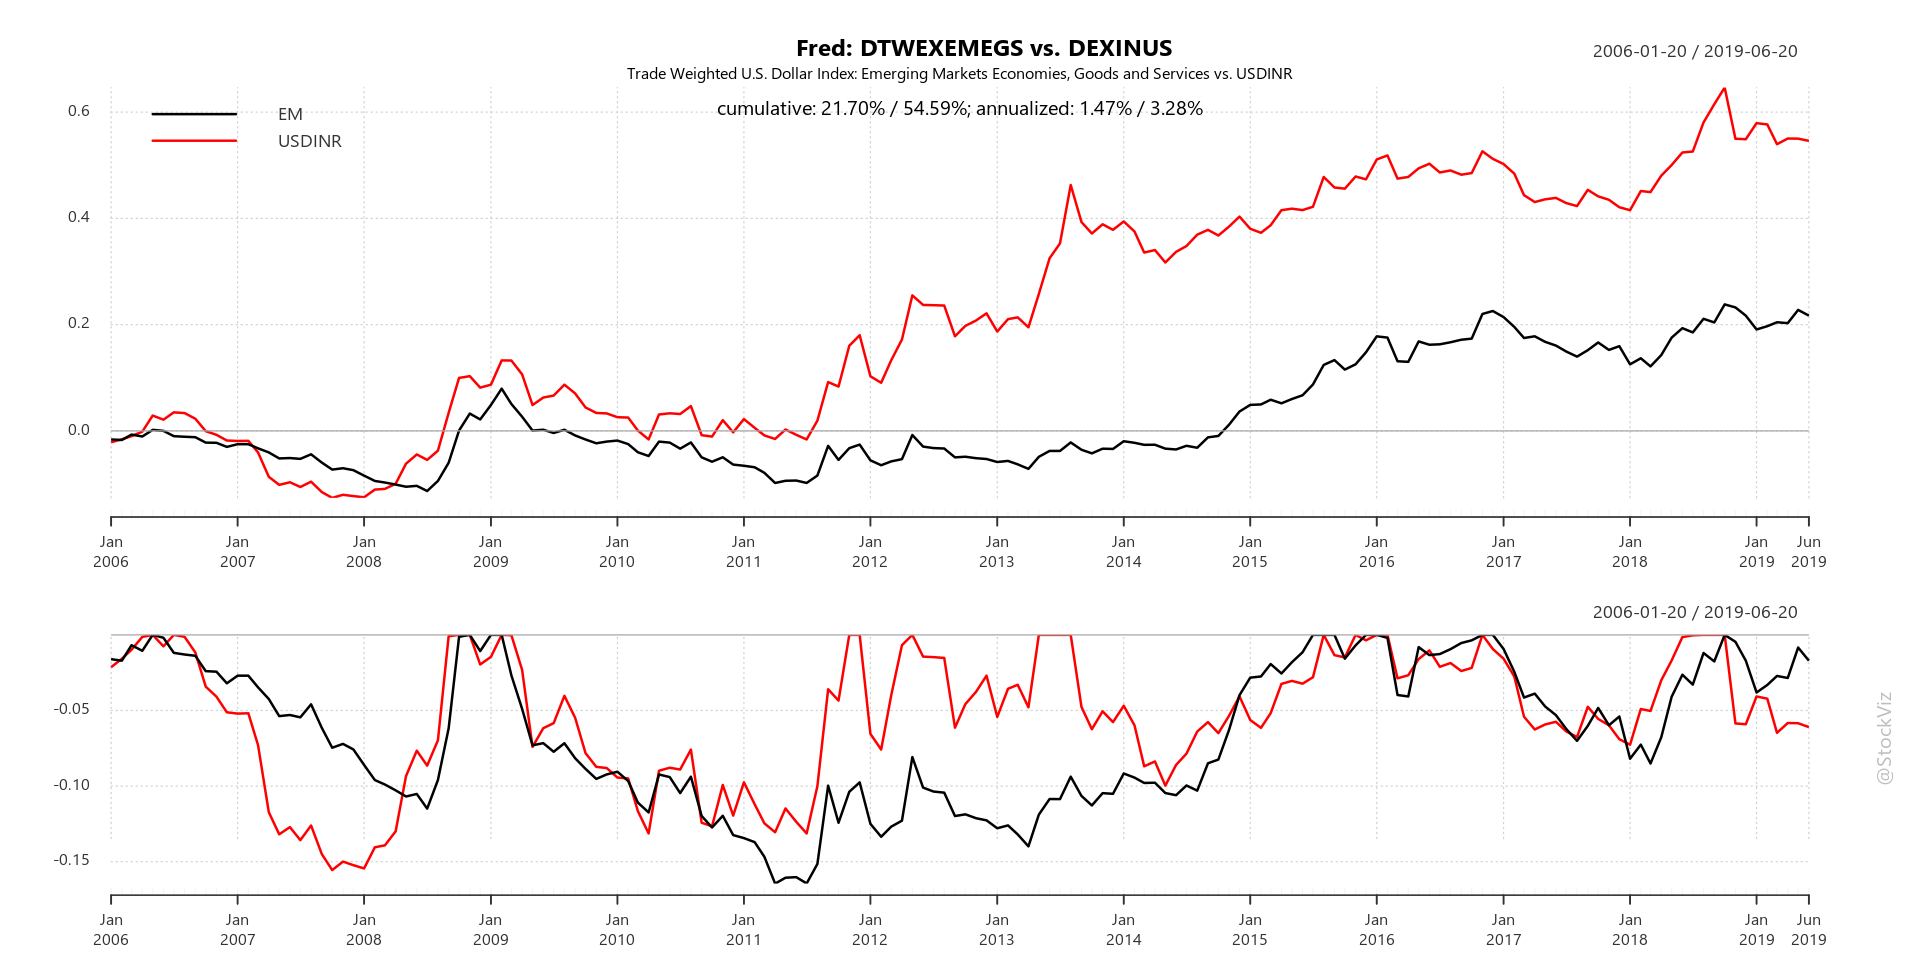

In [7]:
Common.PlotCumReturns(monthlies, "Fred: DTWEXEMEGS vs. DEXINUS", "Trade Weighted U.S. Dollar Index: Emerging Markets Economies, Goods and Services vs. USDINR")

### add the thai bhat to the comparison

In [8]:
fred$Meta() %>% inner_join(fred$TimeSeries(), by = 'SERIES_ID') %>%
    filter(NAME %like% '%exchange%' & NAME %like% '%thai%' & FREQUENCY == 'D') %>%
    group_by(SERIES_ID, TICKER, NAME) %>%
    summarize(MIN_TS = min(TIME_STAMP), MAX_TS = max(TIME_STAMP)) %>%
    filter(MAX_TS >= cutoff) %>%
    select(SERIES_ID, TICKER, NAME, MIN_TS, MAX_TS) %>%
    print(n=Inf)

# Source:   lazy query [?? x 5]
# Database: NORWAY:StockVizUs:R
# Groups:   SERIES_ID, TICKER
    SERIES_ID TICKER  NAME                                  MIN_TS     MAX_TS   
        <int> <chr>   <chr>                                 <chr>      <chr>    
1 -2147478736 DEXTHUS Thailand / U.S. Foreign Exchange Rate 1981-01-02 2019-09-…


In [9]:
c1Id <- -2147478736 #DEXTHUS 

#get 2nd currency data
c1Df <- fred$TimeSeries() %>% 
    filter(SERIES_ID == c1Id & TIME_STAMP >= startDt & TIME_STAMP <= endDt) %>% 
    select(TIME_STAMP, VAL) %>%
    collect() %>%
    mutate(TIME_STAMP = as.Date(TIME_STAMP))

fredDetailsC1 <- fred$Meta() %>% 
    filter(SERIES_ID == c1Id)

#convert to xts
c1Xts <- xts(c1Df$VAL, c1Df$TIME_STAMP)

monthlies <- merge(monthlies, Common.NormalizeMonthlyDates(monthlyReturn(c1Xts)))
names(monthlies) <-c('EM', 'USDINR', 'USDTHB')

print(head(monthlies))

                     EM       USDINR       USDTHB
2006-01-20 -0.016063000 -0.021371327 -0.045878312
2006-02-20 -0.001003113  0.005686988  0.005142710
2006-03-20  0.010404395  0.006107216 -0.006395498
2006-04-20 -0.003724412  0.008543165 -0.034243048
2006-05-20  0.012682445  0.030316540  0.014929352
2006-06-20 -0.001912124 -0.007572479  0.001838718


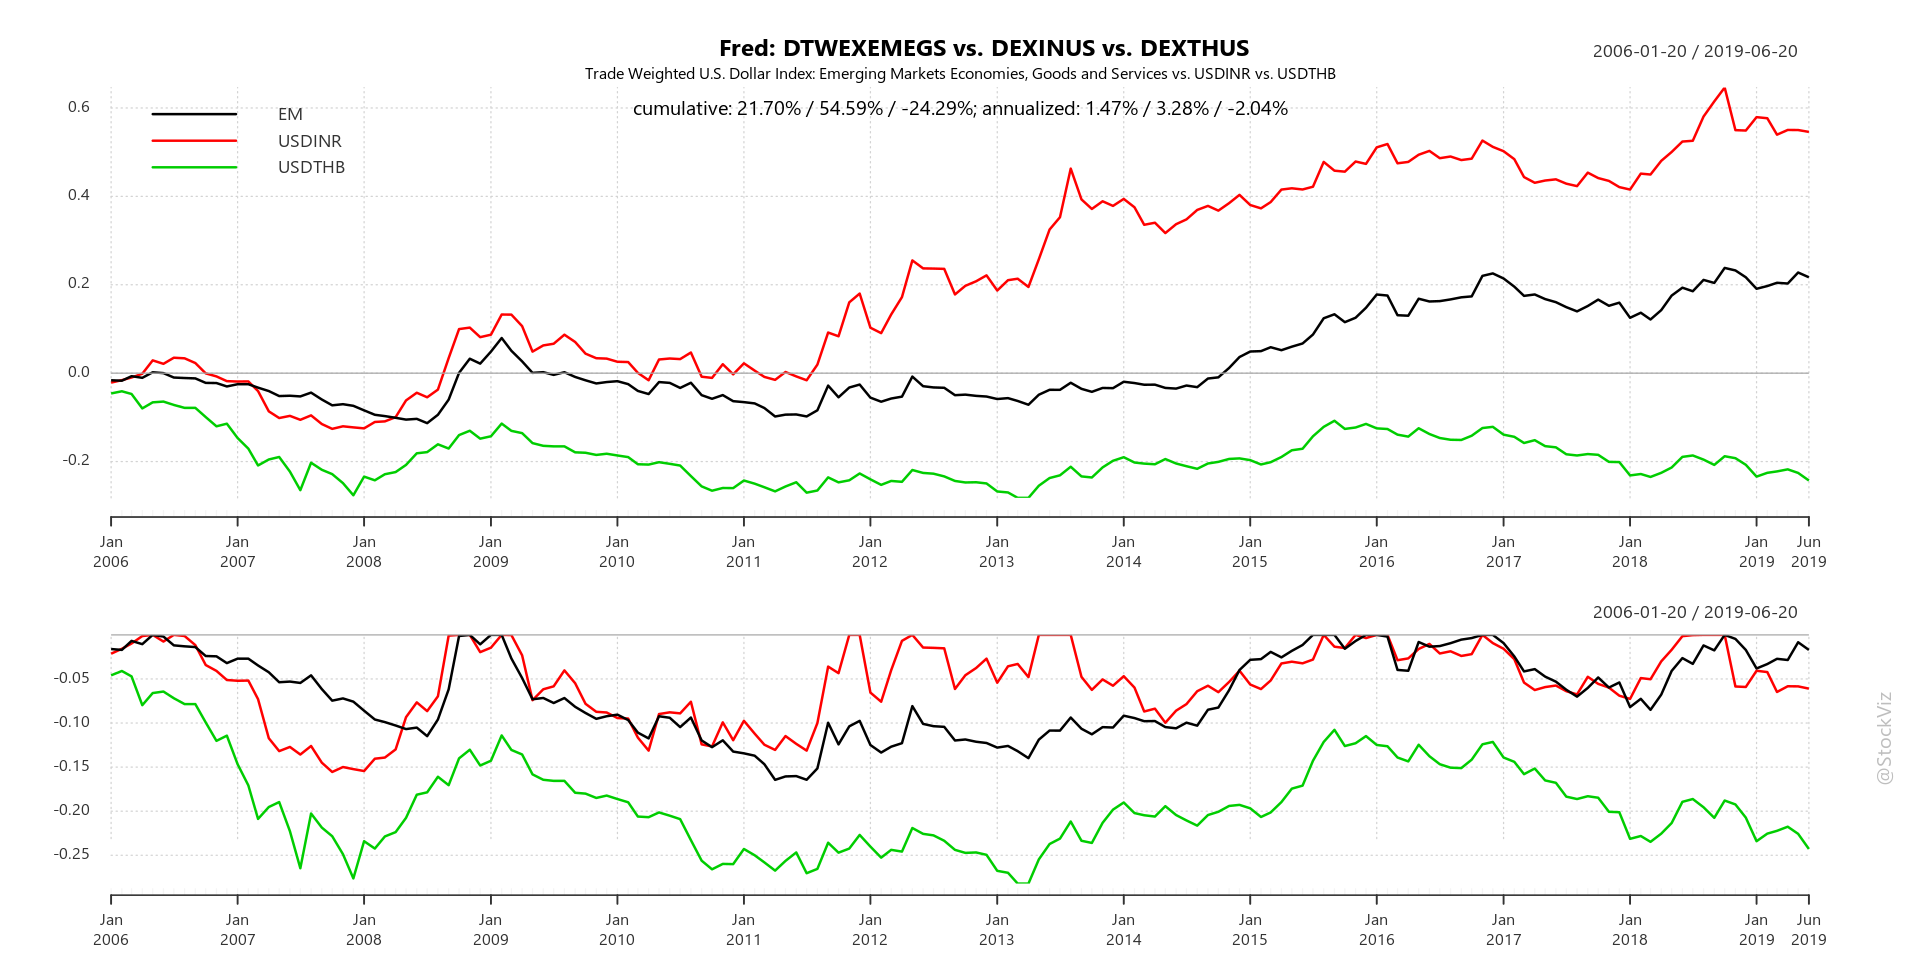

In [10]:
Common.PlotCumReturns(monthlies, "Fred: DTWEXEMEGS vs. DEXINUS vs. DEXTHUS", "Trade Weighted U.S. Dollar Index: Emerging Markets Economies, Goods and Services vs. USDINR vs. USDTHB")

#### If the strength of its currency is a indication of a country's economic health, then what does this say about India's?

This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)